<a id="inicio-notebook"></a>
# Proyecto End to End de Machine Learning 
### Viviendas en venta en Madrid


## 0. Librerías
 

In [3]:
# importación agrupada de librerías necesarias en este notebook
import pandas as pd
import numpy as np


import sys
import os
from datetime import date

from scipy import stats
from scipy.stats import chi2_contingency
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV

from skopt import BayesSearchCV
from skopt.space import Integer, Real

import matplotlib.pyplot as plt
import seaborn as sns

#warnings.filterwarnings('ignore')

# Añado el directorio padre (del que está este notebook) a sys.path
sys.path.append(os.path.abspath('../'))
from scripts.utils_agv import ini_inspec, crear_tabla_resumen, categoricas, numericas

<a id="baseline"></a> 
## 17. ¿Qué modelos? Baseline

### Configuración para visualizaciones

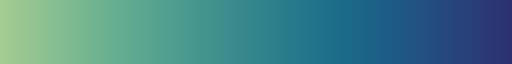

In [4]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.color_palette("crest", as_cmap=True)

(viene del notebook anterior, el conjunto de datos 'test' aquí NUNCA llegan los datos de test) He guardado los dataframe a probar en formato parquet.

Primero, importamos el parquet que queremos probar en todos nuestros modelos.

**Dataframe sin outliers, df5, solo con las 10 características seleccionadas con Feature Importance dentro de Random Forest**

In [5]:
# introduzco aquí el Dataframe en cuestión 
file = 'train_sinOutliers_df5.parquet'
file_path = f'../data/processed/{file}' 
df = pd.read_parquet(file_path, engine="pyarrow")

In [6]:
# (del notebook anterior) Listado de las mejores características correlacionadas con "price"
seleccion_RFfi = ['priceLog',
        'terraza' , 'size', 'floor', 'bathrooms', 'barrio_Lavapiés-Embajadores', 'numPhotos', 
         'hasLift', 'rooms', 'status', 'barrio_Chueca-Justicia', 'exterior'
]

# Filtrar el DataFrame con solo esas columnas
df = df[seleccion_RFfi]
df.head(10)

,priceLog,terraza,size,floor,bathrooms,barrio_Lavapiés-Embajadores,numPhotos,hasLift,rooms,status,barrio_Chueca-Justicia,exterior
ID,,,,,,,,,,,,
105764161,13.554146,0,0.693188,0.0,0.237845,0,0.879779,0,0.578130,1,0,1
105649259,13.891545,1,0.630708,2.0,0.537493,0,0.584295,1,0.578130,1,1,1
106743824,14.603968,0,0.866369,1.0,0.237845,0,0.779100,1,0.747222,1,0,1
105408030,12.560244,0,0.311003,1.0,0.000000,0,0.448665,1,0.289065,1,0,0
106463569,13.697853,0,0.603131,2.0,0.406598,0,0.517376,1,0.578130,1,0,1
107333147,14.652758,0,0.675097,2.0,0.237845,0,0.474078,1,0.578130,2,1,1
107462893,12.468437,0,0.360236,0.0,0.000000,0,0.666931,0,0.289065,0,0,1
107234286,12.706848,0,0.411136,0.0,0.000000,0,0.811525,0,0.458157,1,0,1
107021222,12.899220,0,0.562083,0.0,0.000000,1,0.598220,1,0.458157,0,0,1


In [7]:
df.shape

(1337, 12)

Primeramente hago una separación de entrenamiento y validación, para evaluar mis modelos:

In [8]:
X = df.drop(['priceLog'], axis=1)  # Eliminamos la variable objetivo
y = df['priceLog']

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) 

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de validación: {X_val.shape}")

Tamaño del conjunto de entrenamiento: (1069, 11)
Tamaño del conjunto de validación: (268, 11)


In [10]:
# Modelo Dummy (Baseline)
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

# Predicción en la escala logarítmica
y_pred_dummy_log = dummy.predict(X_val)

# Transformar los valores a la escala original
y_val_original = np.exp(y_val)  # Revertir log(price)
y_pred_dummy_original = np.exp(y_pred_dummy_log)

# Evaluación con RMSE en la escala original
rmse_dummy = np.sqrt(mean_squared_error(y_val_original, y_pred_dummy_original))
print(f"RMSE (escala original): {rmse_dummy:,.2f} €")

# Evaluación con MAPE en la escala original
mape_dummy = mean_absolute_percentage_error(y_val_original, y_pred_dummy_original) * 100
print(f"MAPE (escala original): {mape_dummy:.2f} %")

RMSE (escala original): 584,693.47 €
MAPE (escala original): 73.68 %


### Baseline
Ahora que tenemos un modelo muy básico de referencia, realizo mi Baseline con varios modelos para regresión.


Modelo: Regresión Lineal
RMSE CV: 0.25
RMSE val (original): 222,234.56 €
MAPE val (original): 18.70 %



Modelo: Ridge
RMSE CV: 0.25
RMSE val (original): 222,625.25 €
MAPE val (original): 18.88 %

Modelo: Lasso
RMSE CV: 0.71
RMSE val (original): 584,693.47 €
MAPE val (original): 73.68 %

Modelo: Random Forest
RMSE CV: 0.24
RMSE val (original): 251,869.06 €
MAPE val (original): 16.83 %

Modelo: Gradient Boosting
RMSE CV: 0.23
RMSE val (original): 213,304.29 €
MAPE val (original): 17.17 %

Modelo: SVR
RMSE CV: 0.25
RMSE val (original): 252,483.06 €
MAPE val (original): 18.93 %

Modelo: Regresión Bayesiana
RMSE CV: 0.25
RMSE val (original): 222,014.46 €
MAPE val (original): 18.70 %

Modelo: KNN Regressor
RMSE CV: 0.36
RMSE val (original): 336,544.08 €
MAPE val (original): 26.43 %


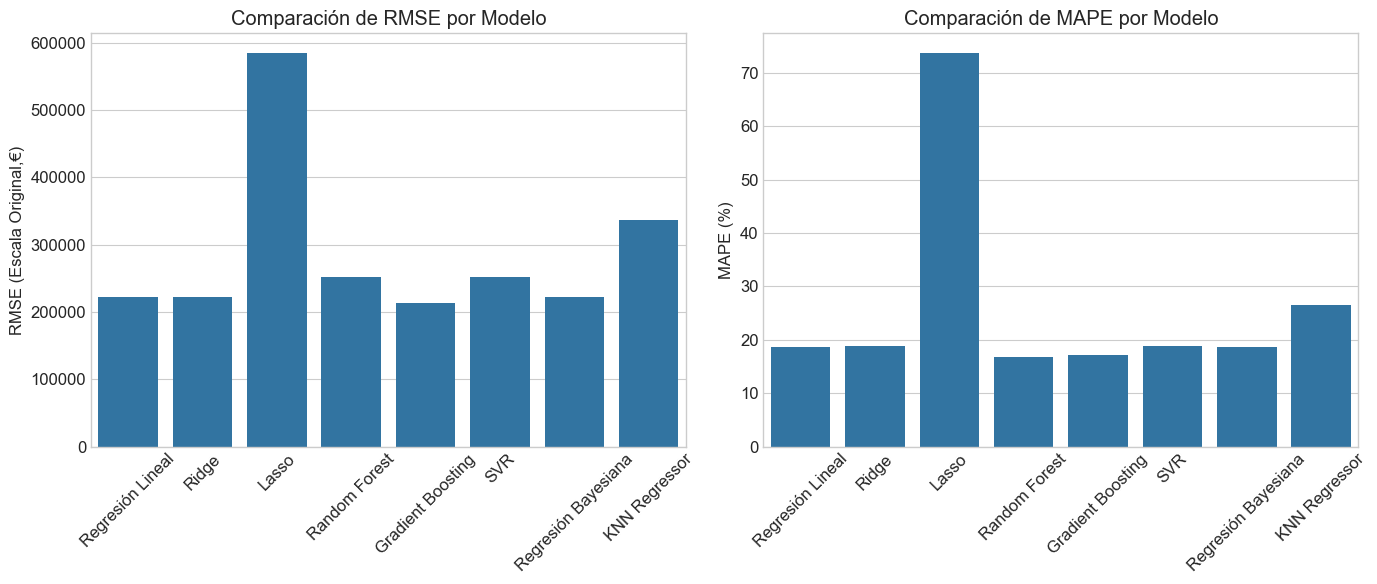

In [11]:
# BASELINE modelos de regresión
def evaluar_modelos(X_train, X_val, y_train, y_val, grafico_error=True):
    """
    Evalúa múltiples modelos de regresión y devuelve métricas de error (RMSE y MAPE) en la escala original.
    
    Parámetros:
        - X_train, X_val: Variables predictoras para entrenamiento y validación
        - y_train, y_val: Variables objetivo en la escala logarítmica
        - grafico_error (bool): Si es True, muestra los gráficos de comparación

    Retorna:
        - resultados (dict): Diccionario con las métricas de cada modelo
    """

    # Definir modelos
    modelos = {
        'Regresión Lineal': LinearRegression(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'SVR': SVR(),
        'Regresión Bayesiana': BayesianRidge(),
        'KNN Regressor': KNeighborsRegressor(n_neighbors=5)  # Nuevo modelo KNN
    }

    resultados = {}

    for nombre, modelo in modelos.items():
        # Validación cruzada (CV) en la escala logarítmica
        mse_cv = -cross_val_score(modelo, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        rmse_cv = np.sqrt(mse_cv)

        # Entrenamiento del modelo
        modelo.fit(X_train, y_train)

        # Predicciones en la escala logarítmica
        y_pred_log = modelo.predict(X_val)

        # Transformar a la escala original
        y_val_original = np.exp(y_val)
        y_pred_original = np.exp(y_pred_log)

        # Evaluación en la escala original
        rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
        mape = mean_absolute_percentage_error(y_val_original, y_pred_original) * 100

        # Guardar resultados
        resultados[nombre] = {
            'RMSE CV': rmse_cv.mean(),
            'RMSE Val': rmse,
            'MAPE Val': mape,
            'Modelo': modelo
        }

        # Imprimir métricas
        print(f"\nModelo: {nombre}")
        print(f"RMSE CV: {rmse_cv.mean():,.2f}")
        print(f"RMSE val (original): {rmse:,.2f} €")
        print(f"MAPE val (original): {mape:.2f} %")

    # Si grafico_error es True, mostramos las comparaciones gráficas
    if grafico_error:
        nombres_modelos = list(resultados.keys())
        rmse_valores = [resultados[m]['RMSE Val'] for m in nombres_modelos]
        mape_valores = [resultados[m]['MAPE Val'] for m in nombres_modelos]

        plt.figure(figsize=(14, 6))

        # Gráfico RMSE
        plt.subplot(1, 2, 1)
        sns.barplot(x=nombres_modelos, y=rmse_valores)
        plt.title('Comparación de RMSE por Modelo')
        plt.xticks(rotation=45)
        plt.ylabel('RMSE (Escala Original,€)')

        # Gráfico MAPE
        plt.subplot(1, 2, 2)
        sns.barplot(x=nombres_modelos, y=mape_valores)
        plt.title('Comparación de MAPE por Modelo')
        plt.xticks(rotation=45)
        plt.ylabel('MAPE (%)')

        plt.tight_layout()
        plt.show()

    return resultados

# Uso de la función
resultados_modelos = evaluar_modelos(X_train, X_val, y_train, y_val, grafico_error=True)


_Reduciendo nuestros datos a las 10 columnas seleccionadas por Feature Importance de Random Forest, los modelos mejoran muy, muy poco, apenas perceptible.  El mejor modelo, de momento, es Gradient Boosting, según el error RMSE. Aunque Random Forest tiene menor error medio porcentual (MAPE). También está proximo Regresión Bayesiana._

<a id="hyperparmeters"></a>
<a href="#inicio-notebook"><p style="text-align:right;" href="#inicio-notebook">Volver al inicio</p></a> 
## 18. Elegir hiperparámetros

Con varios de los modelos que han resultado mejores, pero que andan varios muy próximos, voy a ajustar hiperparámetros, a ver cual combinación es la mejor para mis datos.

In [12]:
# REGRESIÓN LINEAL
grid_linear = {
    "fit_intercept": [True, False],  # Incluir o no el término independiente (bias)
    "positive": [True, False]  # Forzar coeficientes positivos
}


# REGRESIÓN RIDGE
grid_ridge = {
    "alpha": [0.01, 0.1, 1.0, 10.0, 100.0],  # Controla la regularización (mayor α = más regularización)
    "fit_intercept": [True, False],  # Incluir o no el término independiente
    "solver": ["auto", "svd", "cholesky", "lsqr", "saga"],  # Diferentes métodos de optimización
    "max_iter": [100, 500, 1000]  # Iteraciones (solo afecta en algunos solvers)
}


# RANDOM FOREST
grid_random_forest = {"n_estimators": [120], # El Random Forest no suele empeorar por exceso de
                                             # estimadores. A partir de cierto numero no merece la pena
                                             # perder el tiempo ya que no mejora mucho más la precisión.
                                             # Entre 100 y 200 es una buena cifra

                     
                     "max_depth": [3,4,5,6,10,15,17], # No le afecta tanto el overfitting como al decissiontree.
                                                      # Podemos probar mayores profundidades
                      
                     "max_features": ["sqrt", 3, 4] # Numero de features que utiliza en cada split.
                                                    # cuanto más bajo, mejor generalizará y menos overfitting.
                                                    
                     }


# GRADIENT BOOSTING
grid_gradient_boosting = {"loss": ["deviance"], # Deviance suele ir mejor.
                          "learning_rate": [0.05, 0.1, 0.2, 0.4, 0.5],  # Cuanto más alto, mas aporta cada nuevo arbol
                          
                          "n_estimators": [20,50,100,200], # Cuidado con poner muchos estiamdores ya que vamos a
                                                           # sobreajustar el modelo
                          
                          "max_depth": [1,2,3,4,5], # No es necesario poner una profundiad muy alta. Cada nuevo
                                                    # arbol va corrigiendo el error de los anteriores.
                          
                          
                          "max_features": ["sqrt", 3, 4], # Igual que en el random forest
                          }



In [13]:
# Optimización Grid para Regresión Lineal. Errores en escala original
print("\nRealizando Optimización Grid para Regresión Lineal...")

# Definir el espacio de hiperparámetros para la regresión lineal
grid_linear = {
    "fit_intercept": [True, False],  # Incluir o no el término independiente
    "positive": [True, False]  # Forzar coeficientes positivos
}

# Crear el modelo base de regresión lineal
modelo_linear = LinearRegression()

# Configurar GridSearchCV con validación cruzada de 5 folds
grid_search_linear = GridSearchCV(
    modelo_linear,
    grid_linear,
    cv=5,
    scoring="neg_mean_squared_error",  # Se usa MSE negativo para minimizarlo
    n_jobs=-1
)

# Entrenar el modelo
grid_search_linear.fit(X_train, y_train)

# Obtener el mejor modelo encontrado
mejor_lineal = grid_search_linear.best_estimator_

# Predicciones en la escala logarítmica
y_pred_log = mejor_lineal.predict(X_val)

# Transformar a la escala original (de log a original)
y_val_original = np.exp(y_val)
y_pred_original = np.exp(y_pred_log)

# Evaluación en la escala original
rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
mape = mean_absolute_percentage_error(y_val_original, y_pred_original) * 100

# Imprimir resultados
print(f"\nMejores parámetros: {grid_search_linear.best_params_}")
print(f"Mejor RMSE CV: {-grid_search_linear.best_score_:.2f}")  # Se niega MSE para convertirlo en positivo
print(f"RMSE val (original): {rmse:,.2f} €")
print(f"MAPE val (original): {mape:.2f} %")

# Guardamos el mejor modelo
mejor_modelo_lineal = mejor_lineal



Realizando Optimización Grid para Regresión Lineal...

Mejores parámetros: {'fit_intercept': True, 'positive': False}
Mejor RMSE CV: 0.06
RMSE val (original): 222,234.56 €
MAPE val (original): 18.70 %


In [14]:
# Optimización Grid para Ridge. Errores en escala original
print("\nRealizando Optimización Grid para Regresión lineal Ridge...")

# Definir el espacio de hiperparámetros para Ridge
grid_ridge = {
    "alpha": [0.01, 0.1, 1.0, 10.0, 100.0],  # Controla la regularización
    "fit_intercept": [True, False],  # Incluir o no el término independiente
    "solver": ["auto", "svd", "cholesky", "lsqr", "saga"],  # Métodos de optimización
    "max_iter": [1000, 2000]  # Número de iteraciones
}

# Crear el modelo base Ridge
modelo_ridge = Ridge()

# Configurar GridSearchCV con validación cruzada de 5 folds
grid_search_ridge = GridSearchCV(
    modelo_ridge, 
    grid_ridge, 
    cv=5, 
    scoring="neg_mean_squared_error",  # Se usa MSE negativo para minimizarlo
    n_jobs=-1
)

# Entrenar el modelo
grid_search_ridge.fit(X_train, y_train)

# Obtener el mejor modelo encontrado
mejor_ridge = grid_search_ridge.best_estimator_

# Predicciones en la escala logarítmica
y_pred_log = mejor_ridge.predict(X_val)

# Transformar a la escala original
y_val_original = np.exp(y_val)
y_pred_original = np.exp(y_pred_log)

# Evaluación en la escala original
rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
mape = mean_absolute_percentage_error(y_val_original, y_pred_original) * 100

# Imprimir resultados
print(f"\nMejores parámetros: {grid_search_ridge.best_params_}")
print(f"Mejor RMSE CV: {-grid_search_ridge.best_score_:.2f}")  # Se niega MSE para convertirlo en positivo
print(f"RMSE val (original): {rmse:,.2f} €")
print(f"MAPE val (original): {mape:.2f} %")

# Guardamos el mejor modelo
mejor_modelo = mejor_ridge



Realizando Optimización Grid para Regresión lineal Ridge...



Mejores parámetros: {'alpha': 0.01, 'fit_intercept': True, 'max_iter': 1000, 'solver': 'auto'}
Mejor RMSE CV: 0.06
RMSE val (original): 222,201.59 €
MAPE val (original): 18.70 %


In [13]:
# Optimización Bayesiana para Gradient Boosting. Errores en escala original
print("\nRealizando Optimización Bayesiana para Gradient Boosting...")

# Espacio de búsqueda de hiperparámetros
param_space = {
    'n_estimators': Integer(50, 300),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'subsample': Real(0.6, 1.0)
}

# Optimización Bayesiana con validación cruzada
bayes_search = BayesSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_space,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',  # Usamos MSE para minimizarlo
    n_jobs=-1,
    random_state=42
)

# Entrenar el modelo
bayes_search.fit(X_train, y_train)

# Obtener el mejor modelo
mejor_gb = bayes_search.best_estimator_

# Predicciones en la escala logarítmica
y_pred_log = mejor_gb.predict(X_val)

# Transformar a la escala original
y_val_original = np.exp(y_val)
y_pred_original = np.exp(y_pred_log)

# Evaluación en la escala original
rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
mape = mean_absolute_percentage_error(y_val_original, y_pred_original) * 100

# Imprimir resultados
print(f"\nMejores parámetros: {bayes_search.best_params_}")
print(f"Mejor RMSE CV: {-bayes_search.best_score_:.2f}")  # Negamos MSE para hacerlo positivo y en escala original
print(f"RMSE val (original): {rmse:,.2f} €")
print(f"MAPE val (original): {mape:.2f} %")

# Guardamos el mejor modelo
mejor_modelo = mejor_gb



Realizando Optimización Bayesiana para Gradient Boosting...



Mejores parámetros: OrderedDict([('learning_rate', 0.024166621741563987), ('max_depth', 6), ('min_samples_leaf', 7), ('min_samples_split', 17), ('n_estimators', 257), ('subsample', 0.6008945150939967)])
Mejor RMSE CV: 0.05
RMSE val (original): 222,664.36 €
MAPE val (original): 16.92 %


In [14]:
# Optimización Grid para RF. Errores en escala original
print("\nRealizando Grid Search para Random Forest...")

# Definir el espacio de hiperparámetros para el Random Forest
param_grid = {
    'n_estimators': [50, 100, 200, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8]
}

# Configurar GridSearchCV con validación cruzada de 5 folds
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid,
                            cv=5, scoring='neg_mean_squared_error',  # Usamos MSE para minimizarlo
                            n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor RMSE CV: {grid_search.best_score_:.4f}")

# Obtener el mejor modelo
mejor_rf = grid_search.best_estimator_

# Predicciones en la escala logarítmica
y_pred_log = mejor_rf.predict(X_val)

# Transformar a la escala original (de log a original)
y_val_original = np.exp(y_val)
y_pred_original = np.exp(y_pred_log)

# Evaluación en la escala original
rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
mape = mean_absolute_percentage_error(y_val_original, y_pred_original) * 100

# Imprimir resultados
print(f"\nMejores parámetros: {grid_search.best_params_}")
print(f"Mejor RMSE CV: {grid_search.best_score_:.4f}")
print(f"RMSE val (original): {rmse:,.2f} €")
print(f"MAPE val (original): {mape:.2f} %")

# Guardamos el mejor modelo
mejor_modelo = mejor_rf



Realizando Grid Search para Random Forest...


Mejores parámetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Mejor RMSE CV: -0.0560

Mejores parámetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Mejor RMSE CV: -0.0560
RMSE val (original): 249,064.55 €
MAPE val (original): 16.67 %


Después de probar los mejores hiperparámetros en los cuatro modelos que he seleccionado como "mejores", estos no mejoran demasiado mi modelo, ni definen claramente un ganador diferente que destaque. Así pues, por sencillez y eficiencia (rapidez y coste computacional), me quedo con la Regresión Lineal Ridge, o de cresta o regresión L2 regularizada. Este modelo incluye un termino de penalización que evita que los coeficientes se ajusten demasiado en el entrenamiento, y penaliza los valores grandes de estos coeficientes, forzándoles a ser pequeños, compensando así.

### Comprobación del sobreajuste de los modelos

In [17]:
def verificar_sobreajuste(modelo, X_train, X_val, y_train, y_val):
    """
    Verifica si el modelo está sobreajustado comparando las métricas de entrenamiento y validación.
    
    Parámetros:
        - modelo: El modelo entrenado.
        - X_train, X_val: Variables predictoras para entrenamiento y validación.
        - y_train, y_val: Variables objetivo para entrenamiento y validación.
        
    Retorna:
        - None, pero imprime las métricas.
    """
    # Predicciones en el conjunto de entrenamiento y validación
    y_train_pred = modelo.predict(X_train)
    y_val_pred = modelo.predict(X_val)

    # Transformar a la escala original
    y_train_original = np.exp(y_train)
    y_val_original = np.exp(y_val)
    
    y_train_pred_original = np.exp(y_train_pred)
    y_val_pred_original = np.exp(y_val_pred)

    # Calcular métricas RMSE y MAPE
    rmse_train = np.sqrt(mean_squared_error(y_train_original, y_train_pred_original))
    rmse_val = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))
    mape_train = mean_absolute_percentage_error(y_train_original, y_train_pred_original) * 100
    mape_val = mean_absolute_percentage_error(y_val_original, y_val_pred_original) * 100

    print(f"Modelo: {modelo.__class__.__name__}")
    print(f"RMSE entrenamiento (original): {rmse_train:,.2f} €")
    print(f"RMSE validación (original): {rmse_val:,.2f} €")
    print(f"MAPE entrenamiento (original): {mape_train:.2f} %")
    print(f"MAPE validación (original): {mape_val:.2f} %")

    # Verificar si el modelo está sobreajustado
    if rmse_train < rmse_val and mape_train < mape_val:
        print("El modelo podría estar sobreajustado (overfitting).")
    else:
        print("El modelo parece estar bien ajustado.")

# Ejemplo de uso con mi modelo elegido entrenado
modelo_ridge = Ridge(alpha=0.01, fit_intercept=True, max_iter=1000, solver='lsqr')
modelo_ridge.fit(X_train, y_train)
verificar_sobreajuste(modelo_ridge, X_train, X_val, y_train, y_val)


Modelo: Ridge
RMSE entrenamiento (original): 267,561.48 €
RMSE validación (original): 222,212.53 €
MAPE entrenamiento (original): 19.05 %
MAPE validación (original): 18.70 %
El modelo parece estar bien ajustado.


In [18]:
def graficar_aprendizaje(modelo, X_train, y_train, X_val, y_val):
    """
    Genera un gráfico de aprendizaje para el modelo, mostrando el error de entrenamiento y validación.
    """
    train_errors, val_errors = [], []
    
    # Ajustar el modelo mientras calculamos los errores de entrenamiento y validación
    for i in range(1, 201):
        modelo.n_estimators = i
        modelo.fit(X_train, y_train)
        
        y_train_pred = modelo.predict(X_train)
        y_val_pred = modelo.predict(X_val)
        
        train_errors.append(mean_squared_error(y_train, y_train_pred))
        val_errors.append(mean_squared_error(y_val, y_val_pred))

    # Graficar
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 201), train_errors, label="Error de entrenamiento", color='blue')
    plt.plot(range(1, 201), val_errors, label="Error de validación", color='red')
    plt.title('Gráfico de Aprendizaje')
    plt.xlabel('Número de estimadores (iteraciones)')
    plt.ylabel('Error (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()



In [27]:

def graficar_aprendizaje(modelo, X_train, y_train, X_val, y_val):
    """
    Genera un gráfico de aprendizaje para el modelo, mostrando el error de entrenamiento y validación.
    Además, indica el punto donde el error de entrenamiento es igual al de validación y dibuja una línea vertical.
    Imprime el número de iteraciones a partir de las cuales las 10 siguientes no mejoran.
    """
    train_errors, val_errors = [], []
    
    # Ajustar el modelo mientras calculamos los errores de entrenamiento y validación
    for i in range(1, 301):
        modelo.n_estimators = i
        modelo.fit(X_train, y_train)
        
        y_train_pred = modelo.predict(X_train)
        y_val_pred = modelo.predict(X_val)
        
        train_errors.append(mean_squared_error(y_train, y_train_pred))
        val_errors.append(mean_squared_error(y_val, y_val_pred))

    # Buscar el punto donde los errores de entrenamiento y validación son similares
    for i in range(1, len(train_errors)):
        if abs(train_errors[i] - val_errors[i]) < 1e-4:  # Tolerancia de error (ajustar según sea necesario)
            punto_igual = i
            break
    else:
        punto_igual = None

    # Graficar
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 301), train_errors, label="error de entrenamiento", color='blue')
    plt.plot(range(1, 301), val_errors, label="error de validación", color='red')

    if punto_igual is not None:
        plt.axvline(x=punto_igual, color='green', linestyle='--', label=f'punto igual error: {punto_igual} iteraciones')
    
    plt.title('Gráfico de aprendizaje')
    plt.xlabel('Número de estimadores (iteraciones)')
    plt.ylabel('Error (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Comprobar donde las 10 siguientes iteraciones no mejoran
    for i in range(150, 300):  # Empezamos a revisar desde la iteración 150
        if all(val_errors[i] >= val_errors[i+j] for j in range(1, 11)):  # No mejora en las siguientes 10 iteraciones
            print(f"Las 10 siguientes iteraciones después de la iteración {i} no mejoran.")
            break

In [ ]:
# Comprobación de mi modelo Gradient Boosting ajustados hiperparámetros
#'learning_rate', 0.024166621741563987), ('max_depth', 6), ('min_samples_leaf', 7), ('min_samples_split', 17), ('n_estimators', 257), ('subsample', 0.6008945150939967)
modelo_gb = GradientBoostingRegressor(random_state=42, learning_rate = 0.0241666, max_depth=6, min_samples_leaf=7, min_samples_split=17, n_estimators=100, subsample=0.6008945150939967)
graficar_aprendizaje(modelo_gb, X_train, y_train, X_val, y_val)

<a id="pipelines"></a>
<a href="#inicio-notebook"><p style="text-align:right;" href="#inicio-notebook">Volver al inicio</p></a> 
## 19. Pipelines: definición y prueba

<a id="resultados"></a>
<a href="#inicio-notebook"><p style="text-align:right;" href="#inicio-notebook">Volver al inicio</p></a> 
## 20. Resultados

Métricas finales del mejor modelo (Regresión Ridge):
RMSE: 222212.5301 €
MAPE: 18.7003 %


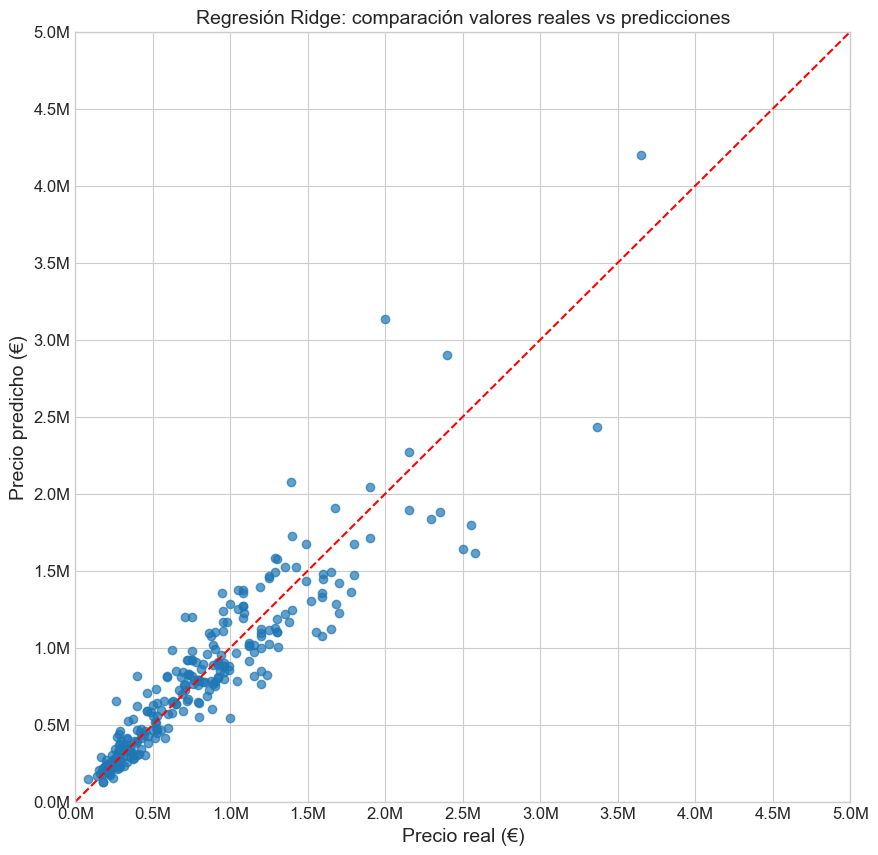


Resultados guardados:
{'RMSE val (original)': np.float64(222212.53006589142), 'MAPE val (original)': 18.70029159745696}


In [15]:
# para modelo Ridge, hiperparámetros mejores ()'alpha': 0.01, 'fit_intercept': True, 'max_iter': 1000, 'solver': 'lsqr'):
# Definir el mejor modelo (Ridge optimizado)
mejor_modelo = Ridge(alpha=0.01, fit_intercept=True, max_iter=1000, solver='lsqr')

# Entrenar el modelo con los datos de entrenamiento (suponiendo que ya tienes X_train y y_train)
mejor_modelo.fit(X_train, y_train)

# Realizar predicciones en la escala logarítmica
y_pred_log = mejor_modelo.predict(X_val)

# Transformar las predicciones y los valores reales de vuelta a la escala original
y_val_original = np.exp(y_val)  # Transformar los valores reales
y_pred_original = np.exp(y_pred_log)  # Transformar las predicciones

# Evaluar el rendimiento del modelo en la escala original
rmse_final = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
mape_final = mean_absolute_percentage_error(y_val_original, y_pred_original) * 100

# Imprimir las métricas finales
print("Métricas finales del mejor modelo (Regresión Ridge):")
print(f"RMSE: {rmse_final:.4f} €")
print(f"MAPE: {mape_final:.4f} %")

# Visualizar las predicciones vs los valores reales
plt.figure(figsize=(10, 10))  # Hacer el gráfico cuadrado

# Ajustar los límites de los ejes para que lleguen hasta 10M
plt.xlim(0, 5e6)
plt.ylim(0, 5e6)

# Visualizar
plt.scatter(y_val_original, y_pred_original, alpha=0.7)
plt.plot([0, 5e6], [0, 5e6], 'r--')  # Línea de referencia 45º

# Etiquetas
plt.xlabel('Precio real (€)', fontsize=14)
plt.ylabel('Precio predicho (€)', fontsize=14)
plt.title('Regresión Ridge: comparación valores reales vs predicciones', fontsize=14)

# Ajustar los ejes para que utilicen 0.5M, 1M, 1.5M, etc., hasta 10M
plt.xticks(np.arange(0, 5.5e6, step=0.5e6), 
           labels=[f'{x/1e6}M' for x in np.arange(0, 5.5e6, step=0.5e6)])

plt.yticks(np.arange(0, 5.5e6, step=0.5e6), 
           labels=[f'{y/1e6}M' for y in np.arange(0, 5.5e6, step=0.5e6)])
plt.show()

# Guardar resultados para análisis posterior
resultados = {
    'RMSE val (original)': rmse_final,
    'MAPE val (original)': mape_final
}

# Imprimir resultados
print("\nResultados guardados:")
print(resultados)
